In [17]:
"""Produce histogram of discriminant from tagger output and labels."""
from __future__ import annotations

import numpy as np
import pandas as pd
from ftag import Flavours
from ftag import Cuts
from ftag.hdf5 import H5Reader

from puma import Histogram, HistogramPlot
from puma.utils import get_good_linestyles
from puma.metrics import calc_rej
from puma import Roc, RocPlot

In [18]:
! h5ls -v "data/2023-12-07/epoch=004-val_loss=0.05191__test_ttbar.h5"

Opened "data/2023-12-07/epoch=004-val_loss=0.05191__test_ttbar.h5" with sec2 driver.
electron_tracks          Dataset {300000/300000, 40/40}
    Location:  1:800
    Links:     1
    Chunks:    {1172, 1} 131264 bytes
    Storage:   1344000000 logical bytes, 1031518809 allocated bytes, 130.29% utilization
    Filter-0:  lzf-32000 OPT {4, 261, 131264}
    Type:      struct {
                   "valid"            +0    enum native signed char {
                       FALSE            = 0
                       TRUE             = 1
                   }
                   "pt"               +1    native float
                   "eta"              +5    16-bit little-endian floating-point
                   (significant for 10 bits at bit 0, msb implied)
                   (exponent for 5 bits at bit 10, bias is 0xf)
                   (sign bit at 15)
                   "phi"              +7    16-bit little-endian floating-point
                   (significant for 10 bits at bit 0, msb imp

In [19]:
fname = "logs/TPLTmu_20231207-T121930/ckpts/epoch=017-val_loss=0.05193__test_ttbar.h5"
reader = H5Reader(fname, batch_size=100, jets_name="muons")
cuts = Cuts.from_list(["pt > 10e3", "eta < 2.5", "eta > -2.5"])
data = reader.load({"muons": None}, num_jets=100_000)
idx, muons = cuts(data["muons"])
tagger = "TPLTmu"

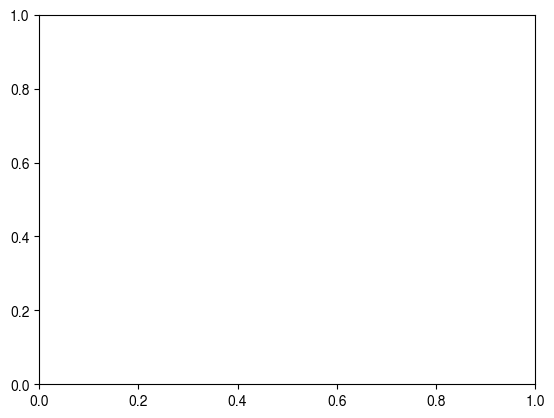

In [20]:
# Calculate discriminant score
df = pd.DataFrame(muons)
df[f"disc_{tagger}"] = np.log(
    df[f"{tagger}_pmuxprompt"] / (df[f"{tagger}_pnpxall"])
)

# defining boolean arrays to select the different flavour classes
is_prompt = df["iffClass"] == 4
is_nonprompt = df["iffClass"] != 4

taggers = [tagger]
linestyles = get_good_linestyles()[:1]

# Initialise histogram plot
plot_histo = HistogramPlot(
    n_ratio_panels=0,
    ylabel="Normalised number of muons",
    xlabel=f"{tagger} discriminant",
    logy=True,
    leg_ncol=1,
    figsize=(6, 3),
    bins=np.linspace(-10, 10, 50),
    y_scale=1.5,
    atlas_second_tag="$\\sqrt{s}=13$ TeV, muons\n $t\overline{t}$ events, test data",
)

# Add the histograms
for tagger, linestyle in zip(taggers, linestyles):
    plot_histo.add(
        Histogram(
            df[is_prompt][f"disc_{tagger}"],
            # Only specify the label for the case of the "DIPS" light-jets, since we
            # want to hide the legend entry for "RNNIP" light-jets as it has the same
            # linecolour. Instead, we specify a "linestyle legend" further down in the
            # script
            label="Prompt muons",
            colour="blue",
            linestyle=linestyle,
        ),
    )
    plot_histo.add(
        Histogram(
            df[is_nonprompt][f"disc_{tagger}"],
            label="Non-prompt muons",
            colour="red",
            linestyle=linestyle,
        )
    )
    

plot_histo.draw()
plot_histo.savefig("histogram_discriminant.png", transparent=False)

r22 908.0947068293656
37
37
r21 244.42139729418585


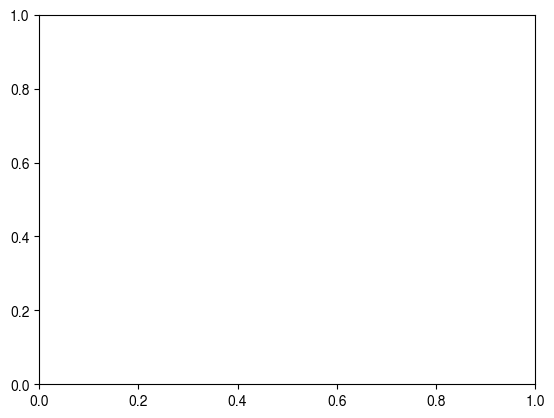

In [24]:
# plot ROC curve
sig_eff = np.linspace(0.69, 1, 200)

n_prompt = sum(is_prompt)
n_nonprompt = sum(is_nonprompt)


def disc_fct(arr: np.ndarray) -> np.ndarray:
    """Tagger discriminant.

    Parameters
    ----------
    arr : numpy.ndarray
        array with with shape (, 2)

    Returns
    -------
    np.ndarray
        Array with the discriminant values inside.
    """
    return np.log(arr[1] / arr[0])

discs = np.apply_along_axis(
    disc_fct, 1, df[[f"{tagger}_pnpxall", f"{tagger}_pmuxprompt"]].values
)
nonpromptprompt_rej = calc_rej(discs[is_prompt], discs[is_nonprompt], sig_eff)

plot_roc = RocPlot(
    n_ratio_panels=0,
    ylabel="Background rejection",
    xlabel="Prompt-muon efficiency",
    atlas_second_tag="$\\sqrt{s}=13$ TeV, muons\n $t\overline{t}$ events, test data",
    figsize=(6, 4),
    y_scale=1.4,
)
plot_roc.add_roc(
    Roc(
        sig_eff,
        nonpromptprompt_rej,
        n_test=n_nonprompt,
        rej_class="ujets",
        signal_class="bjets",
        label=tagger,
    ),
    reference=True
)

dx = np.diff(1 - nonpromptprompt_rej)  # Differences in x-values
dy = (sig_eff[:-1] + sig_eff[1:]) / 2  # Average of consecutive y-values
auc = np.sum(dx * dy)
print("r22 " + str(auc))

epsilon_s = np.array([0.70039012, 0.70585176, 0.71092328, 0.71794538, 0.72613784, 0.7343303, 
 0.74408322, 0.7503251, 0.76046814, 0.7686606, 0.77724317, 0.78582575, 
 0.79284785, 0.8029909, 0.81430429, 0.83029909, 0.84395319, 0.85643693, 
 0.8716515, 0.88452536, 0.90052016, 0.91222367, 0.92080624, 0.9289987, 
 0.93836151, 0.9473342, 0.95552666, 0.96176853, 0.96762029, 0.97269181, 
 0.98010403, 0.98478544, 0.98790637, 0.99219766, 0.9953186, 0.99726918, 
 0.99921977]
)
print(len(epsilon_s))

epsilon_b = np.array([306.28153152, 290.92057772, 279.90758343, 269.31149345, 255.80469993, 
 233.77731929, 219.21456871, 210.91605366, 190.29040894, 176.15596196, 
 165.18263339, 152.91314914, 143.38769108, 129.36569739, 113.75047328, 
 95.00378798, 82.46855933, 72.51410416, 58.27072465, 49.93571962, 
 40.12723597, 33.51405325, 28.72022574, 24.93074951, 20.82202889, 
 17.39044736, 14.52440879, 12.60799273, 10.80455398, 8.90856926, 
 6.97690339, 5.82707247, 4.86673981, 3.52836353, 2.69311493, 2.0033797, 
 1.01315031]
)

print(len(epsilon_s))


dx = np.diff(1 - epsilon_b)  # Differences in x-values
dy = (epsilon_s[:-1] + epsilon_s[1:]) / 2  # Average of consecutive y-values
auc = np.sum(dx * dy)
print("r21 " + str(auc))

plot_roc.add_roc(
    Roc(
        epsilon_s,
        epsilon_b,
        n_test=n_nonprompt,
        rej_class="ujets",
        signal_class="bjets",
        label="PLIV r21",
        colour="red"
    ),
)

# Marker
MARKER_X = 0.9
MARKER_Y = 46
plot_roc.axis_top.plot(MARKER_X, MARKER_Y, 'x', markersize=18, color='red', label="r21 PromptLeptonImprovedVeto WP")


plot_roc.draw()
plot_roc.savefig("roc.png", transparent=False)

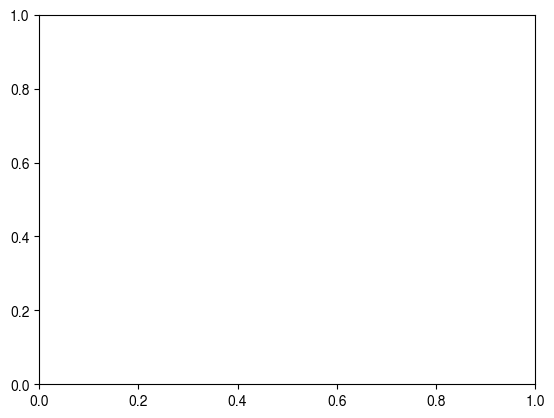

In [25]:
"""Produce pT vs efficiency plot from tagger output and labels."""
from __future__ import annotations

from puma import VarVsEff, VarVsEffPlot

def disc_fct(arr: np.ndarray) -> np.ndarray:
    """Tagger discriminant.

    Parameters
    ----------
    arr : numpy.ndarray
        array with with shape (, 2)

    Returns
    -------
    np.ndarray
        Array with the discriminant values inside.
    """
    return np.log(arr[1] / arr[0])

discs = np.apply_along_axis(
    disc_fct, 1, df[[f"{tagger}_pnpxall", f"{tagger}_pmuxprompt"]].values
)


# Getting muon pt in GeV
pt = df["pt"].values / 1e3
# defining target efficiency
sig_eff = np.linspace(0.7, 1, 20)
# defining boolean arrays to select the different flavour classes
is_prompt = df["iffClass"] == 4
is_nonprompt = df["iffClass"] != 4

# here the plotting starts

# define the curves
ptvseff = VarVsEff(
    x_var_sig=pt[is_prompt],
    disc_sig=discs[is_prompt],
    x_var_bkg=pt[is_nonprompt],
    disc_bkg=discs[is_nonprompt],
    bins=[10, 15, 20, 25, 30, 35, 40, 50, 60, 80, 100, 150, 200],
    working_point=0.8,
    disc_cut=None,
    flat_per_bin=True,
    label="TPLTmu",
)


# You can choose between different modes: "sig_eff", "bkg_eff", "sig_rej", "bkg_rej"
plot_bkg_rej = VarVsEffPlot(
    mode="bkg_rej",
    ylabel="Non-prompt lepton rejection",
    xlabel=r"$p_{T}$ [GeV]",
    logy=False,
    atlas_second_tag="$\\sqrt{s}=13$ TeV, muons\n $t\overline{t}$ events, test data, $\epsilon$(prompt)=0.8 in each bin",
)
plot_bkg_rej.add(ptvseff, reference=True)

plot_bkg_rej.draw()
plot_bkg_rej.savefig("pt_rej.png")

plot_eff_rej = VarVsEffPlot(
    mode="bkg_eff",
    ylabel="Non-prompt lepton efficiency",
    xlabel=r"$p_{T}$ [GeV]",
    logy=False,
    atlas_second_tag="$\\sqrt{s}=13$ TeV, muons\n $t\overline{t}$ events, test data, $\epsilon$(prompt)=0.8 in each bin",
)
plot_eff_rej.add(ptvseff, reference=True)
plot_eff_rej.draw()
plot_eff_rej.savefig("pt_eff.png")